![rapids motivation](images/rapids_motivation.png)


# <center>Scaling Hyper-Parameter Optimization with RAPIDS + Dask + [ Kubernetes ]</center>
-----

<center> In this notebook you can try different hyper-parameter search methods using synthetic or real data. </center>
 
&nbsp;

| method name | &nbsp;&nbsp;&nbsp; performance | &nbsp;&nbsp;&nbsp; search duration  |
|-----------------------|-----------------|------------------|
| random-search         | &nbsp;&nbsp;&nbsp; worst | &nbsp;&nbsp;&nbsp; slow    |
| particle-search [1]      | &nbsp;&nbsp;&nbsp; good  | &nbsp;&nbsp;&nbsp; fast    |
| async-particle-search | &nbsp;&nbsp;&nbsp; best  | &nbsp;&nbsp;&nbsp; fastest |

<center>[1] https://en.wikipedia.org/wiki/Particle_swarm_optimization#Algorithm</center>


# Table of Contents

1. [ Generate a classification dataset on GPU ](#data-load) (e.g., double helix, unwinding helix/whirl )

2. [ ETL - process/prepare data for model training ](#ETL) (e.g., scale, split, augment )   
    
3. [ Define HPO Strategy ](#define-hpo)

4. [ Create Compute Cluster ](#compute-cluster)
   > LocalCUDACluster or KubeCluster
      
5. [ Define Seach ](#define-search)

6. [ Run Classic Particle Swarm ](#run-classic-PSO)

7. [ Run ASYNC Particle Swarm ](#run-async-PSO)

8. [ Run Random Search Baseline ](#run-random-search)

9. [ Summary ](#summary)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipyvolume as ipv
import matplotlib.pyplot as plt

import numpy as np; import pandas as pd; import cudf
import cuml; import xgboost

import time; import copy 

import data_utils               # load datasets (or generate data) on the gpu
import swarm                    # particle swarm implementation
import visualization as viz     # visualization

In [3]:
# reload library modules/code without a kernel restart
import importlib; importlib.reload( swarm ); importlib.reload( data_utils ); importlib.reload( viz);

<a id = 'data-load'></a>
----
# 1. Load/Generate Data 
----

This notebook works with a dataset (data + binary labels) that can either be generated or loaded.

Note that you are also welcome to bring your own dataset. The available datasets we provide include:

| Name                                                      | Default Samples | Max Samples | Columns | Task  |
|-----------------------------------------------------------|-----------------|-------------|---------|-------|
| **synthetic** helix                                       | 800K            | Inf         | 3       | Binary Classification |
| [airline](http://kt.ijs.si/elena_ikonomovska/data.html)   | 25M             | 115M        | 13      | Binary Classification |
| [higgs](https://archive.ics.uci.edu/ml/datasets/HIGGS)    | 5M              | 11M         | 28      | Binary Classification |


In addition to specifying a dataset, you can also choose the number of samples that will be loaded/generated -- this is helpful to make for a compelling demo in a short amount of time as well as to stay within memory limits.



In [4]:
datasetName = 'synthetic'
nSamples = 1000000

In [5]:
if datasetName == 'synthetic':
        
    data, labels, elapsedTime  = data_utils.generate_dataset( coilType = 'helix', nSamples = nSamples)

elif datasetName == 'higgs':
    
    nSamplesToLoad = np.min( ( nSamples, 11000000 ))
    data, labels, elapsedTime = data_utils.load_higgs_dataset ( 'data/', nSamplesToLoad)
    
elif datasetName == 'airline':
    
    nSamplesToLoad = np.min( ( nSamples, 115000000 ))    
    data, labels, elapsedTime = data_utils.load_airline_dataset ( 'data/', nSamplesToLoad)

print(f'dataset shape: {data.shape}\n > loaded in {elapsedTime} s')

generating blobs; # points = 500000
generating blobs; # points = 500000
dataset shape: (1000000, 3)
 > loaded in 1.6125342845916748 s


## 1.1) Plot Dataset

In the case of the synthetic dataset, the feature dimensionality is 3, so we do no need to do any reduction prior to 3D plotting.

For real datasets with many features, we first apply a dimensionality reduction method prior to plotting.

In the cells below we demonstrate several approaches to dimensionality reduction available in RAPIDS [ cuml ] :

* PCA (linear, unsupervised), 
* TSNE (non-linear, unsupervised), and 
* UMAP (non-linear, supervised)

In [6]:
if datasetName == 'synthetic':
    viz.plot_data( data, labels, datasetName )
else:
    viz.plot_data( data, labels, datasetName, dimReductionMethod = 'PCA')

plotting SYNTHETIC dataset, original shape: (1000000, 3)
 > plotting subset of 100000 samples -- 10.0% of total, adjust via maxSamplesToPlot 


In [7]:
if datasetName != 'synthetic':
    viz.plot_data( data, labels, datasetName, dimReductionMethod = 'UMAP', maxSamplesForDimReduction = 100000 )

In [8]:
if datasetName != 'synthetic':
    viz.plot_data( data, labels, datasetName, dimReductionMethod = 'TSNE', maxSamplesForDimReduction = 25000 )

<a id = 'ETL'></a>

# 2. ETL
-----

## 2.1) Split Data into Train & Test Sets

In [9]:
if datasetName == 'synthetic':
    trainTestOverlap = .022
    trainData, trainLabels, testData, testLabels, _ = data_utils.split_train_test_nfolds ( data, labels, trainTestOverlap = trainTestOverlap )
else:
    trainData, testData, trainLabels, testLabels = cuml.train_test_split( data, labels, shuffle = True )

splitting data into training and test set


## 2.2) Re-scale / Normalize

In [10]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

In [11]:
# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData )
_,_, t_scaleTest = scale_dataframe_inplace ( testData, trainMeans, trainSTDevs ) 

rescaling data
rescaling data


## 2.3) Train vs Test Data Comparison

In [12]:
# TODO: train vs test data viz
# TODO: data_utils.plot_iid_breaking( trainData.to_pandas(), testData.to_pandas() )

<a id = 'define-hpo'></a>

# 3. Define HPO Strategy
-----

### Particle Swarm : 
> Particles are randomly initialized, and change their position in hyper-parameter space using three terms 
1. momentum
2. personal best 
3. global best
<center>    
$ velo_{t+1} = velo_t * w_{momentum} + (pos_{personal-best} - pos_{current}) * w_{personal} + (pos_{global-best} - pos_{current}) * w_{global} $
   $ pos_{t+1} = pos_{t} + velo_{t+1} $
</center>

### Particle Evaluation Logic 
> (i.e., Train & Eval using Changing Parameter Sets )

In [13]:
def evaluate_particle ( particle, dataFutures, earlyStoppingRounds, retainPredictionsFlag ):    

    # fixed parameters
    paramsGPU = { 'objective': 'binary:hinge',
                  'tree_method': 'gpu_hist',
                  'n_gpus': 1,
                  'random_state': 0 }

    # TODO: loop over paramRanges instead of hard code
    paramsGPU['max_depth'] = int( particle['params'][0] )
    paramsGPU['learning_rate'] = particle['params'][1]
    paramsGPU['gamma'] = particle['params'][2]
    paramsGPU['num_boost_rounds'] = 1000

    startTime = time.time()

    trainDMatrix = xgboost.DMatrix( data = dataFutures['trainData'], label = dataFutures['trainLabels'] )
    testDMatrix = xgboost.DMatrix( data = dataFutures['testData'], label = dataFutures['testLabels'] )

    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], 
                                     params = paramsGPU,
                                     num_boost_round = paramsGPU['num_boost_rounds'],
                                     early_stopping_rounds = earlyStoppingRounds,
                                     verbose_eval = False )
        
    predictionsGPU = trainedModelGPU.predict( testDMatrix ).astype(int)
            
    elapsedTime = time.time() - startTime

    particle['nTrees'] = trainedModelGPU.best_iteration
    particle['trainAccuracy'] = 1 - float( trainedModelGPU.eval(trainDMatrix, iteration = 50).split(':')[1] )
    particle['testAccuracy'] = 1 - float( trainedModelGPU.eval(testDMatrix, iteration = 50).split(':')[1] )    
    
    if not retainPredictionsFlag: 
        predictionsGPU = None
    
    particle['predictions'] = predictionsGPU
    
    return particle, elapsedTime

### Particle Update Logic 
https://en.wikipedia.org/wiki/Particle_swarm_optimization

In [14]:
def update_particle( particle, paramRanges, globalBestParams, personalBestParams, 
                     wMomentum, wIndividual, wSocial, wExplore, randomSearchMode = False, randomSeed = None ):
    ''' 
    # TODO: debug dask caching [?] attempting to use a seed produces the same sequence of random samples
    if randomSeed is not None:
        np.random.seed(randomSeed)    
    '''
    
    # baseline to compare swarm update versus random search
    if randomSearchMode:        
        sampledParams, sampledVelocities = swarm.sample_params( paramRanges )
        return sampledParams, sampledVelocities
        
    # computing update terms for particle swarm
    inertiaInfluence = particle['velocities'].copy()
    socialInfluence = ( globalBestParams - particle['params'] )
    individualInfluence = ( personalBestParams - particle['params'] )
    
    newParticleVelocities =    wMomentum    *  inertiaInfluence \
                             + wIndividual  *  individualInfluence  * np.random.random()   \
                             + wSocial      *  socialInfluence      * np.random.random()
    
    newParticleParams = particle['params'].copy() + newParticleVelocities
    newParticleParams = swarm.enforce_param_bounds_inline ( newParticleParams, paramRanges )
            
    return newParticleParams, newParticleVelocities

### HPO Run Loop

In [15]:
def run_hpo ( client, mode, paramRanges, trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF,
              nParticles, nEpochs,             
              wMomentum = .05, wIndividual = .35, wBest = .25, wExplore = .15, earlyStoppingRounds = 50,
              terminationAccuracy = np.Inf, 
              randomSeed = 0, 
              plotFlag = False,
              retainPredictionsFlag = False ):
    
    startTime = time.time()
    
    # ----------------------------
    # scatter data to all workers
    # ----------------------------
    if client is not None:
        scatteredData_future = client.scatter( [ trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF], broadcast = True )
        
    dataFutures = { 'trainData'   : scatteredData_future[0], 'trainLabels' : scatteredData_future[1], 
                    'testData'    : scatteredData_future[2], 'testLabels'  : scatteredData_future[3] }
    
    # ----------------------------
    # initialize HPO strategy 
    # ----------------------------        
    def initialize_particle_futures ( nParticles, paramRanges, randomSeed, plotFlag ) :
        initialParticleParams, initialParticleVelocities, globalBest, particleColors = swarm.initialize_particle_swarm ( nParticles, paramRanges, randomSeed, plotFlag )
        # create particle futures using the initialization positions and velocities    
        delayedEvalParticles = []
        for iParticle in range(nParticles):
            particle = { 'ID': iParticle, 'params': initialParticleParams[iParticle], 'velocities': initialParticleVelocities[iParticle], 'predictions': None }        
            delayedEvalParticles.append( delayed ( evaluate_particle )( particle.copy(), dataFutures, earlyStoppingRounds, retainPredictionsFlag ))
        return delayedEvalParticles, initialParticleParams, globalBest, particleColors
        
    # ------------------------------------------------
    # shared logic for particle evaluation and updates
    # ------------------------------------------------
    def eval_and_update ( particleFuture, delayedEvalParticles, particleHistory, paramRanges, globalBest, randomSearchMode, nEvaluations ):
        # convert particle future to concrete result and collect returned values
        particle, elapsedTime = particleFuture.result()

        # update hpo strategy meta-parameters -- i.e. swarm global best and particle personal best
        particleHistory, globalBest = swarm.update_bests ( particleHistory, particle, globalBest, nEvaluations, mode['randomSearch'] )

        # update history with this particle's latest contribution/eval
        particleHistory = swarm.update_history_dictionary ( particleHistory, particle, nEvaluations )

        # update particle
        if randomSearchMode:
            personalBestParams = None
        else:
            personalBestParams = particleHistory[particle['ID']]['personalBestParams']
            
        particle['params'], particle['velocities'] = update_particle ( particle, paramRanges,
                                                                       globalBest['params'], personalBestParams,
                                                                       wMomentum, wIndividual, wBest, wExplore,
                                                                       randomSearchMode = randomSearchMode, 
                                                                       randomSeed = particle['ID'] ) # repeatability
        return particle.copy(), particleHistory, globalBest
    
    nEvaluations = 0
    particleHistory = {}
    
    if mode['allowAsyncUpdates'] != True:
        # ----------------------------
        # synchronous particle swarm
        # ----------------------------
        delayedEvalParticles, initialParticleParams, globalBest, particleColors = initialize_particle_futures ( nParticles, paramRanges, randomSeed, plotFlag )
        futureEvalParticles = client.compute( delayedEvalParticles )
        
        for iEpoch in range (0, nEpochs ):    
            futureEvalParticles = client.compute( delayedEvalParticles )
            delayedEvalParticles = []
            for particleFuture in futureEvalParticles:
                newParticle, particleHistory, globalBest = eval_and_update ( particleFuture, delayedEvalParticles, particleHistory, paramRanges, globalBest, mode['randomSearch'], nEvaluations )

                # termination conditions 
                if globalBest['accuracy'] > terminationAccuracy: break

                # append future work for the next instantiation of this particle ( using the freshly updated parameters )
                delayedEvalParticles.append( delayed ( evaluate_particle )( newParticle, dataFutures, earlyStoppingRounds, retainPredictionsFlag ))
                
                nEvaluations += 1
            # --- 
            print(f' > on epoch {iEpoch} out of {nEpochs}') 
    
    else:
        # ----------------------------
        # asynchronous particle swarm
        # ----------------------------
        delayedEvalParticles, initialParticleParams, globalBest, particleColors = initialize_particle_futures ( nParticles, paramRanges, randomSeed, plotFlag )
        futureEvalParticles = client.compute( delayedEvalParticles )        
        particleFutureSeq = as_completed( futureEvalParticles )
        
        for particleFuture in particleFutureSeq:
            newParticle, particleHistory, globalBest = eval_and_update ( particleFuture, delayedEvalParticles, particleHistory, paramRanges, globalBest, mode['randomSearch'], nEvaluations )
            
            # termination conditions 
            if globalBest['accuracy'] > terminationAccuracy: break
            approximateEpoch = nEvaluations // nParticles
            if ( approximateEpoch ) > nEpochs : break
            
            # append future work for the next instantiation of this particle ( using the freshly updated parameters )
            delayedParticle = delayed ( evaluate_particle )( newParticle, dataFutures, earlyStoppingRounds, retainPredictionsFlag )
            # submit this particle future to the client ( returns a future )
            futureParticle = client.compute( delayedParticle )
            # track its completion via the as_completed iterator 
            particleFutureSeq.add( futureParticle )
            
            nEvaluations += 1
            if nEvaluations % nParticles == 0:
                print(f' > on approximate epoch {approximateEpoch} out of {nEpochs}') 
                              
    elapsedTime = time.time() - startTime
    
    print(f"\n\n best accuracy: {globalBest['accuracy']}, by particle: {globalBest['particleID']} on eval: {globalBest['iEvaluation']} ")
    print(f" best parameters: {swarm.format_params( globalBest['params'], globalBest['nTrees'] )}, \n elpased time: {elapsedTime:.2f} seconds")
    
    particleHistory['initialParams'] = initialParticleParams
    particleHistory['paramRanges'] = paramRanges
    particleHistory['particleColors'] = particleColors
    particleHistory['nParticles'] = nParticles
    return particleHistory, globalBest, elapsedTime

### Inspect/Edit Library Code [optional]
> swarm.import_library_function_in_new_cell ( **function-name** )

In [16]:
import inspect

In [17]:
sampleImportFlag = False
if sampleImportFlag:
    swarm.import_library_function_in_new_cell ( [ swarm.sample_params, swarm.initialize_particle_swarm] )

<a id = 'compute-cluster'></a>

# 4. Create Compute Cluster
-----

In [18]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster

from dask.distributed import Client
from dask.distributed import as_completed
from dask.distributed import worker

In [19]:
cluster = LocalCUDACluster( ip = '', n_workers = 4)

In [20]:
''' # TODO -- finalize dask_kubernetes check on RAPIDS 0.10.0 cuda 10.1
from dask_kubernetes import KubeCluster
cluster = KubeCluster( ip = '' )
''';

In [21]:
client = Client( cluster, asynchronous = True)

<a id = 'define-search'></a>

# 5. Define Search: 
-----

Define hyper-parameter ranges

In [22]:
paramRanges = { 0: ['max_depth', 3, 20, 'int'],
                1: ['learning_rate', .001, 1, 'float'],
                2: ['gamma', 0, 2, 'float'] }

Define SWARM size (nParticles) particles and search duration (nEpochs)

In [23]:
nParticles = 32
nEpochs = 15

### 5.1) Baseline / Demo : Single Particle for a Single Epoch

In [24]:
mode = {'allowAsyncUpdates': False, 'randomSearch': False }
particleHistory, globalBest, _ = run_hpo ( client, mode, paramRanges, 
                                           trainData, trainLabels, testData, testLabels, 
                                           nParticles = 1, nEpochs = 1, randomSeed = 0)

0.905190 -- new global best by particle: 0, eval: 0, params: 15, 0.8444, 1.6945, 21
 > on epoch 0 out of 1


 best accuracy: 0.9051899999999999, by particle: 0 on eval: 0 
 best parameters: 15, 0.8444, 1.6945, 21, 
 elpased time: 4.25 seconds


<a id = 'run-classic-PSO'></a>
# 6. Run **Classic-Particle-Swarm**
-----




Typically classic-particle-swarm reaches higher performance than random-search, but lower performance relative to async-particle-search
* Wall Clock Time: Typically this is search process.

* Performance: Typically this search method reaches the best result.


* Description: Particles move using a random mixture of personal and global best

* Parallelism: Partial-Asynchronous
  * NOTE: Particles update in parallel with their peers within an epoch, but wait for the slowest particle at epoch boundaries. All particles are guaranteed to have the same number of evaluations ( see nEvaluations figure ).

In [25]:
mode = {'allowAsyncUpdates': False, 'randomSearch': False }
particleHistory, globalBest, _ = run_hpo ( client, mode, paramRanges, 
                                           trainData, trainLabels, testData, testLabels,
                                           nParticles, nEpochs,
                                           wMomentum = .05, wIndividual = .25, wBest = .45, wExplore = 0,
                                           plotFlag = False, 
                                           retainPredictionsFlag = True )

0.905190 -- new global best by particle: 0, eval: 0, params: 15, 0.8444, 1.6945, 21
0.919750 -- new global best by particle: 3, eval: 3, params: 8, 0.8701, 1.5983, 29
0.922120 -- new global best by particle: 9, eval: 9, params: 7, 0.6354, 1.1637, 64
0.930430 -- new global best by particle: 11, eval: 11, params: 6, 0.8212, 1.6759, 49
 > on epoch 0 out of 15
 > on epoch 1 out of 15
 > on epoch 2 out of 15
 > on epoch 3 out of 15
 > on epoch 4 out of 15
 > on epoch 5 out of 15
 > on epoch 6 out of 15
 > on epoch 7 out of 15
 > on epoch 8 out of 15
 > on epoch 9 out of 15
 > on epoch 10 out of 15
 > on epoch 11 out of 15
0.935010 -- new global best by particle: 26, eval: 410, params: 5, 0.7848, 1.6772, 77
 > on epoch 12 out of 15
 > on epoch 13 out of 15
 > on epoch 14 out of 15


 best accuracy: 0.93501, by particle: 26 on eval: 410 
 best parameters: 5, 0.7848, 1.6772, 77, 
 elpased time: 129.20 seconds


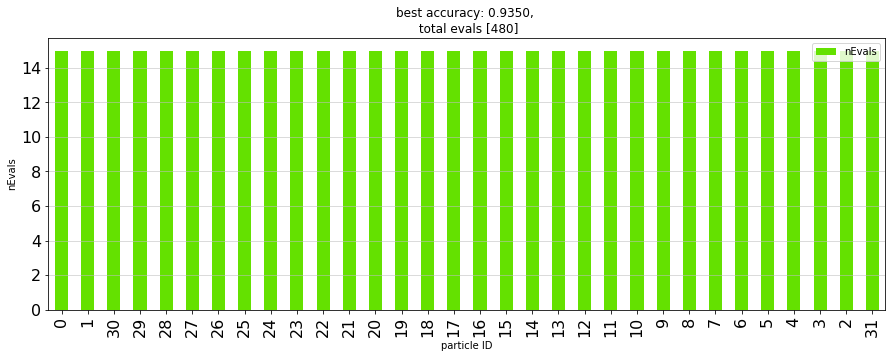

In [26]:
sortedBarHeightsDF = swarm.plot_eval_distribution ( particleHistory,  globalBest['particleID'] );


In [27]:
swarm.viz_particle_movement( particleHistory )

<a id = 'run-async-PSO'></a>
# 7. Run **ASYNC-Particle-Swarm** 
-----

Performance: Typically **better performance** compared to synchronous-particle-swarm and random-search.

Wall Clock Time: Typically this is the **fastest** search process.

* Description: Particles move using a random mixture of personal and global best [ possibly stale ]

* Parallelism: Asynchronous
  * NOTE: Particles update without waiting for their peers causing faster evaluating hyper-parameter particles to run more often ( see nEvaluations figure ).

In [28]:
mode = {'allowAsyncUpdates': True, 'randomSearch': False }
particleHistoryAsync, globalBestAsync, _ = run_hpo ( client, mode, paramRanges,
                                                     trainData, trainLabels, testData, testLabels, 
                                                     nParticles, nEpochs,
                                                     wMomentum = .05, wIndividual = .25, wBest = .45,
                                                     retainPredictionsFlag = True )

0.450330 -- new global best by particle: 23, eval: 0, params: 4, 0.6535, 0.8628, 3
0.914510 -- new global best by particle: 10, eval: 3, params: 6, 0.3387, 0.6344, 98
0.918270 -- new global best by particle: 1, eval: 11, params: 5, 0.3165, 0.9320, 94
0.927190 -- new global best by particle: 10, eval: 14, params: 6, 0.3561, 0.6901, 50
 > on approximate epoch 0 out of 15
 > on approximate epoch 1 out of 15
0.928400 -- new global best by particle: 10, eval: 81, params: 6, 0.3562, 0.6902, 73
0.932330 -- new global best by particle: 23, eval: 89, params: 5, 0.4631, 0.7717, 96
 > on approximate epoch 2 out of 15
 > on approximate epoch 3 out of 15
0.932400 -- new global best by particle: 6, eval: 140, params: 6, 0.4570, 0.7797, 145
 > on approximate epoch 4 out of 15
 > on approximate epoch 5 out of 15
 > on approximate epoch 6 out of 15
 > on approximate epoch 7 out of 15
0.935660 -- new global best by particle: 21, eval: 280, params: 5, 0.4479, 0.7707, 91
 > on approximate epoch 8 out of 1

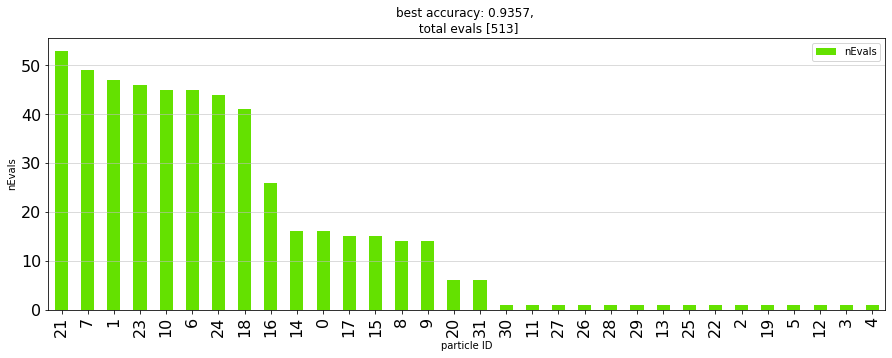

In [29]:
sortedBarHeightsDF = swarm.plot_eval_distribution ( particleHistoryAsync,  globalBestAsync['particleID'] );

In [30]:
swarm.viz_particle_movement( particleHistoryAsync )

<a id = 'run-random-search'></a>
# 8. Run **Random-Search-Baseline**
-----

Performance: Typically random search **performs worse** than the particle swarm variants.

Wall Clock Time: Typically this is the **slowest** search process.

* Description: Particles telport to new [random ] positions in hyper-parameter space
* Parallelism: Asynchronous
  * NOTE: Particles update without waiting for their peers, and randomly adopt new parameter combinations. Long runs (e.g.,  nEpochs = 30000) should produce balanced nEvaluations per-particle, though imbalance is often visible for shorter runs [ less imbalanced than ASYNC PSO, more imbalanced than PSO ]

In [31]:
mode = {'allowAsyncUpdates': True, 'randomSearch': True }
particleHistoryBaseline, globalBestBaseline, _ = run_hpo ( client, mode, paramRanges, 
                                                           trainData, trainLabels, testData, testLabels,  
                                                           nParticles, nEpochs,
                                                           retainPredictionsFlag = True )

0.882440 -- new global best by particle: 26, eval: 0, params: 5, 0.1677, 1.7299, 115
0.915460 -- new global best by particle: 26, eval: 2, params: 10, 0.6398, 0.2738, 14
0.924170 -- new global best by particle: 17, eval: 4, params: 5, 0.7355, 0.4975, 67
0.924770 -- new global best by particle: 19, eval: 15, params: 6, 0.2981, 0.7930, 67
0.928970 -- new global best by particle: 5, eval: 19, params: 16, 0.8822, 1.4483, 27
 > on approximate epoch 0 out of 15
0.930430 -- new global best by particle: 11, eval: 50, params: 6, 0.8212, 1.6759, 49
 > on approximate epoch 1 out of 15
 > on approximate epoch 2 out of 15
 > on approximate epoch 3 out of 15
0.931320 -- new global best by particle: 17, eval: 142, params: 5, 0.5739, 0.9701, 85
0.931970 -- new global best by particle: 7, eval: 147, params: 15, 0.9912, 1.6133, 4
 > on approximate epoch 4 out of 15
 > on approximate epoch 5 out of 15
 > on approximate epoch 6 out of 15
 > on approximate epoch 7 out of 15
 > on approximate epoch 8 out of

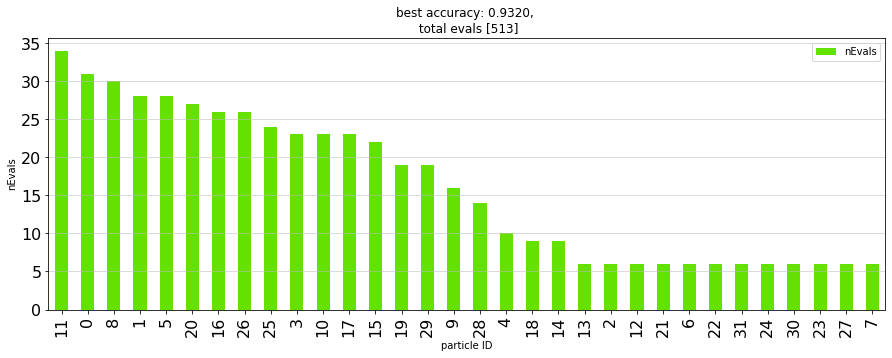

In [32]:
sortedBarHeightsDF = swarm.plot_eval_distribution ( particleHistoryBaseline,  globalBestBaseline['particleID'] );

In [33]:
swarm.viz_particle_movement( particleHistoryBaseline )

<a id = 'summary'></a>
# 9. Summary
-----

Async Scaling > Sync Scaling > Random Search

# 10. Extensions

larger than single GPU memory datasets - dask_cudf + [ dask_xgboost or xgboost.dask ]